<a href="https://colab.research.google.com/github/SuryaB98/ML_Model_POC/blob/main/XGBoost_Churn_Rate_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1️⃣  Setup & Package Installation
# -----------------------------------------------------------------------
!pip install -q xgboost shap seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             precision_recall_curve, precision_score,
                             recall_score, f1_score, confusion_matrix)
import warnings, os, json, joblib
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-muted")


In [3]:
# 2️⃣  Load Dataset (Upload or Mount GDrive)
# -----------------------------------------------------------------------
# Replace the path as needed. If using GDrive, uncomment & mount.
# from google.colab import drive; drive.mount('/content/drive')

DATA_PATH = "/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df_raw = pd.read_csv(DATA_PATH)

print(f"Shape: {df_raw.shape}")
df_raw.head()


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# New Section

# New Section

In [4]:
# 3️⃣  Clean & Pre-Process
# -----------------------------------------------------------------------
df = df_raw.copy()

# Handle blanks in TotalCharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"].replace(" ", np.nan))
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Drop customerID (leakage)
df.drop(columns=["customerID"], inplace=True)

# Binary-encode target
df["Churn"] = (df["Churn"] == "Yes").astype(int)

# Separate numeric & categorical
num_cols  = ["tenure", "MonthlyCharges", "TotalCharges", "SeniorCitizen"]
cat_cols  = [c for c in df.columns if c not in num_cols + ["Churn"]]

# One-hot encode
df = pd.get_dummies(df, columns=cat_cols, drop_first=False)

X = df.drop("Churn", axis=1)
y = df["Churn"]

print("Final feature matrix:", X.shape)


Final feature matrix: (7043, 45)


In [5]:
# 4️⃣  Train/Test Split (80/20 stratified)
# -----------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Class imbalance weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("scale_pos_weight =", round(scale_pos_weight,2))


scale_pos_weight = 2.77


In [6]:
# 5️⃣  Build XGBoost Classifier (Recall-Optimized)
# -----------------------------------------------------------------------
xgb_clf = xgb.XGBClassifier(
    n_estimators      = 300,
    learning_rate     = 0.08,
    max_depth         = 4,
    subsample         = 0.8,
    colsample_bytree  = 0.8,
    reg_lambda        = 3,
    scale_pos_weight  = scale_pos_weight,
    random_state      = 42,
    eval_metric       = "logloss"
)
xgb_clf.fit(X_train, y_train)

print("Model trained with", xgb_clf.n_estimators, "trees")


Model trained with 300 trees


In [7]:
# 6️⃣  Threshold Optimisation (≥80 % Recall)
# -----------------------------------------------------------------------
y_proba = xgb_clf.predict_proba(X_test)[:,1]
prec, rec, thr = precision_recall_curve(y_test, y_proba)

target_recall = 0.80
opt_thr, opt_prec = 0.50, 0.0
for p,r,t in zip(prec, rec, thr):
    if r >= target_recall:
        opt_thr, opt_prec = t, p
        break

print(f"Optimal threshold = {opt_thr:.3f}  →  Recall ≥ 80 %")


Optimal threshold = 0.002  →  Recall ≥ 80 %


ROC-AUC   : 0.8382
PR-AUC    : 0.6518
Precision : 0.2654
Recall    : 1.0000
F1-Score  : 0.4195


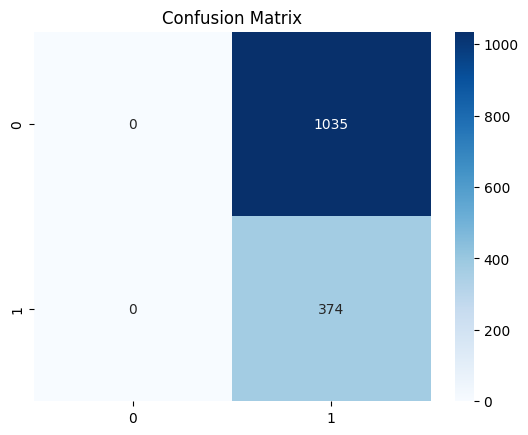

In [8]:
# 7️⃣  Evaluation Metrics
# -----------------------------------------------------------------------
y_pred = (y_proba >= opt_thr).astype(int)

metrics = {
    "ROC-AUC"  : roc_auc_score(y_test, y_proba),
    "PR-AUC"   : average_precision_score(y_test, y_proba),
    "Precision": precision_score(y_test, y_pred),
    "Recall"   : recall_score(y_test, y_pred),
    "F1-Score" : f1_score(y_test, y_pred)
}
for k,v in metrics.items():
    print(f"{k:<10}: {v:.4f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix"); plt.show()


In [9]:
# 8️⃣  Cross-Validation (5-Fold Recall & ROC-AUC)
# -----------------------------------------------------------------------
cv_recall = cross_val_score(
    xgb_clf, X_train, y_train,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring="recall"
)
cv_auc = cross_val_score(
    xgb_clf, X_train, y_train,
    cv=5, scoring="roc_auc"
)
print(f"CV Recall  : {cv_recall.mean():.4f} ± {cv_recall.std()*2:.4f}")
print(f"CV ROC-AUC : {cv_auc.mean():.4f} ± {cv_auc.std()*2:.4f}")


CV Recall  : 0.7552 ± 0.0551
CV ROC-AUC : 0.8382 ± 0.0213


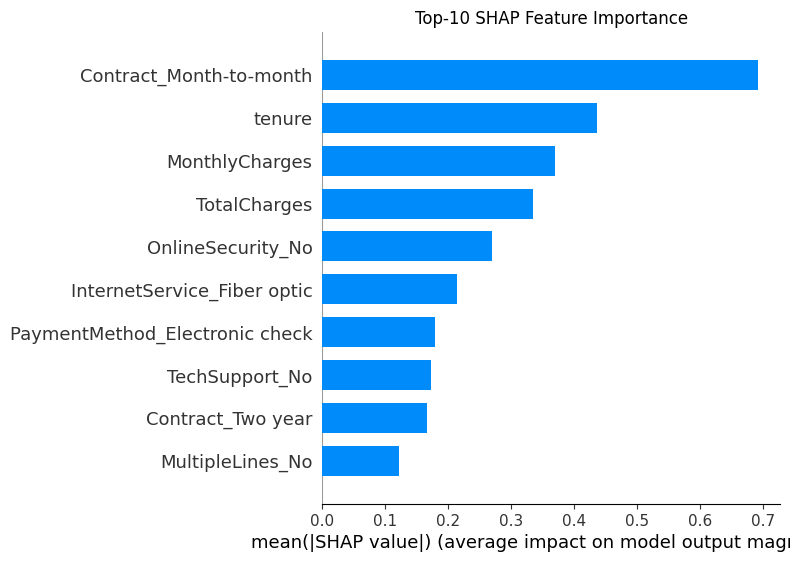

In [10]:
# 9️⃣  SHAP Interpretability (Top Drivers)
# -----------------------------------------------------------------------
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test, check_additivity=False)

shap.summary_plot(shap_values, X_test, plot_type="bar",
                  max_display=10, show=False)
plt.title("Top-10 SHAP Feature Importance"); plt.show()


,customers,churners,churn_rate,lift
decile,,,,
1,141,110,0.780142,2.939091
2,141,77,0.546099,2.057363
3,141,59,0.418440,1.576421
4,141,46,0.326241,1.229074
5,141,35,0.248227,0.935165
6,140,19,0.135714,0.511287
7,141,15,0.106383,0.400785
8,141,6,0.042553,0.160314
9,141,4,0.028369,0.106876


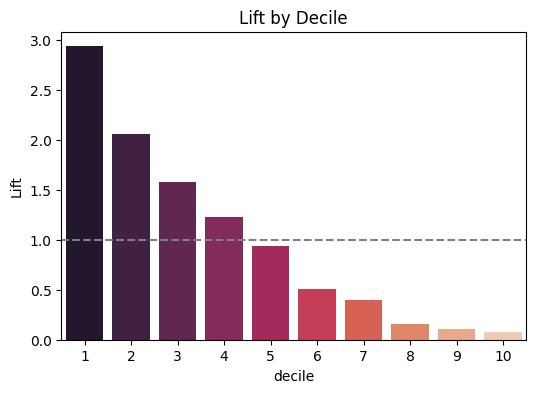

In [11]:
# 🔟  Lift / Gain Chart (Decile Analysis)
# -----------------------------------------------------------------------
test_df = pd.DataFrame({"proba": y_proba, "actual": y_test})
test_df = test_df.sort_values("proba", ascending=False).reset_index(drop=True)
test_df["decile"] = pd.qcut(test_df.index, 10, labels=False)+1

lift_tbl = (test_df.groupby("decile")
            .agg(customers=("actual","size"),
                 churners =("actual","sum"))
            .assign(churn_rate = lambda d: d.churners/d.customers)
           )
overall = y_test.mean()
lift_tbl["lift"] = lift_tbl.churn_rate / overall
display(lift_tbl)

plt.figure(figsize=(6,4))
sns.barplot(x=lift_tbl.index, y=lift_tbl.lift, palette="rocket")
plt.axhline(1, ls="--", c="gray"); plt.ylabel("Lift"); plt.title("Lift by Decile")
plt.show()


In [12]:
# 1️⃣1️⃣  Risk Segmentation & Business List
# -----------------------------------------------------------------------
segments = pd.cut(
    y_proba, bins=[0,0.3,0.7,1], labels=["Low","Medium","High"]
)
seg_counts = segments.value_counts().reindex(["High","Medium","Low"])
print(seg_counts)

# Export high-risk list (>70 %)
high_risk_idx = segments == "High"
high_risk_customers = df_raw.loc[y_test.index[high_risk_idx]]
high_risk_customers.to_csv("high_risk_customers.csv", index=False)
print("High-risk customer list saved ➜ high_risk_customers.csv")


High      343
Medium    380
Low       686
Name: count, dtype: int64
High-risk customer list saved ➜ high_risk_customers.csv


In [13]:
# 1️⃣2️⃣  Save Artifacts (Model, Features, Threshold)
# -----------------------------------------------------------------------
os.makedirs("artifacts", exist_ok=True)

joblib.dump(xgb_clf, "artifacts/xgb_churn_model.joblib")
with open("artifacts/feature_list.json","w") as f:
    json.dump(list(X.columns), f)
with open("artifacts/threshold.txt","w") as f:
    f.write(str(opt_thr))

print("Artifacts saved in ./artifacts/")


Artifacts saved in ./artifacts/


In [14]:
# 1️⃣3️⃣  Batch Scoring Function Example
# -----------------------------------------------------------------------
def score_customers(df_new, model_path="artifacts/xgb_churn_model.joblib",
                    feat_path="artifacts/feature_list.json",
                    thr_path ="artifacts/threshold.txt"):
    model  = joblib.load(model_path)
    feats  = json.load(open(feat_path))
    thr    = float(open(thr_path).read())

    df_proc = pd.get_dummies(df_new, drop_first=False)
    df_proc = df_proc.reindex(columns=feats, fill_value=0)
    proba   = model.predict_proba(df_proc)[:,1]
    flag    = (proba >= thr).astype(int)
    return pd.DataFrame({"Churn_Probability": proba,
                         "Churn_Flag": flag})

# Demo on 5 random test customers
demo = df_raw.sample(5, random_state=1)
score_customers(demo)


,Churn_Probability,Churn_Flag
0,0.173617,1
1,0.213476,1
2,0.602030,1
3,0.804042,1
4,0.569644,1
